# Statistical analysis

In [6]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed.csv"
d = pd.read_csv(datafilename)
#d = d[-72:] # use just the data for the  last participant

# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

## Participants

In [7]:
print("Number of participants:")
print(len(d["Participant ID"].unique()))
print()
print("Fluent vs. non-native:")
print(d["Fluent"].value_counts() / 72) # there is 72 trials
print()
print("Different kinds of designers:")
print(d["Designer"].value_counts() / 72)
print()
print("Which font was first:")
print(d[d["Test ID"] == 1]["Font"].value_counts() / 36)



Number of participants:
39

Fluent vs. non-native:
True     49.0
False     4.0
Name: Fluent, dtype: float64

Different kinds of designers:
Letter designer     20.0
Non-designer        15.0
Graphic designer     9.0
Typographer          5.0
Other designer       4.0
Name: Designer, dtype: float64

Which font was first
sansforgetica    31.0
arial            22.0
Name: Font, dtype: float64


## JoM for categories of designers

In [8]:
display(d.groupby("Designer")["JoM"].mean())

Designer
Graphic designer    58.166667
Letter designer     57.775000
Non-designer        52.966667
Other designer      50.625000
Typographer         61.000000
Name: JoM, dtype: float64

## JoL for categories of designers (draft)

In [9]:
display(d.groupby("Designer")["JoL"].value_counts() / 36)

Designer          JoL                   
Graphic designer  very easy to read          8.0
                  ok                         4.0
                  easy to read               3.0
                  very difficult to read     2.0
                  difficult to read          1.0
Letter designer   very easy to read         12.0
                  difficult to read         10.0
                  ok                         8.0
                  easy to read               7.0
                  very difficult to read     3.0
Non-designer      very easy to read         12.0
                  difficult to read          7.0
                  ok                         7.0
                  easy to read               2.0
                  very difficult to read     2.0
Other designer    ok                         4.0
                  very easy to read          3.0
                  difficult to read          1.0
Typographer       very easy to read          4.0
                  difficult 

## Calculating AUC and RT

In [10]:
fonts = set(d["Font"].unique())

result_columns = ["Study ID", "Participant ID", "Test ID", "Test type",
                  "Native", "Designer", "Font", "Correct", "Response time",
                  "Response time (word)", "Response time (non-word)",
                  "AUC", "AUC (word)", "AUC (non-word)",
                  "JoL", "JoM", "Date"]
agg_columns = {k:"first" for k in set(d.columns).intersection(result_columns)}
agg_columns["Correct"] = "mean"
agg_columns["Response time"] = "mean"
results = d.groupby(["Study ID", "Participant ID", "Test ID", "Test type"]).agg(agg_columns)
results = pd.DataFrame(results, columns=result_columns)
results.set_index(["Study ID", "Participant ID", "Test ID", "Test type"], inplace=True)

# prepare indexes for temporary data frames
ix = {}
test_ids = set(d["Test ID"].unique())
category_used = "Category"
categories = ["word", "non-word"]
responses = ["Sure word", "Probably word", "Probably non-word", "Sure non-word"]
ix["lexical"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))
category_used = "Seen"
categories = ["seen", "not seen"]
responses = ["Sure seen", "Probably seen", "Probably not seen", "Sure not seen"]
ix["recognition"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))

for sid in d["Study ID"].unique():
    for pid in d[d["Study ID"] == sid]["Participant ID"].unique():
        for tid in test_ids:
            dt = d[(d["Study ID"] == sid) & (d["Participant ID"] == pid) & (d["Test ID"] == tid)]
            for ttype in dt["Test type"].unique():
                category_used, index = ix[ttype]
                # ensure the order in the index is always the same
                dg = pd.DataFrame(index=index)
                dg["Frequencies"] = dt[dt["Test type"] == ttype].groupby([category_used])["Response"].value_counts()
                dg = dg.fillna(0)
                # frequencies for word/seen -> y coordinate
                # frequencies for non-word/not seen -> x coordinate
                freqs = dg["Frequencies"].tolist()
                auc = get_auc(freqs[4:], freqs[:4])
                results.loc[(sid, pid, tid, ttype), "AUC"] = auc
                rt = dt[dt["Test type"] == ttype]["Response time"].mean()
                results.loc[(sid, pid, tid, ttype), "Response time"] = rt
                for cat in ["word", "non-word"]:
                    if ttype == "recognition":
                        dg["Frequencies"] = dt[(dt["Test type"] == ttype) & (dt["Category"] == cat)].groupby([category_used])["Response"].value_counts()
                        dg = dg.fillna(0)
                        freqs = dg["Frequencies"].tolist()
                        auc = get_auc(freqs[4:], freqs[:4])
                        results.loc[(sid, pid, tid, ttype), "AUC (%s)" % cat] = auc
                    rt = dt[(dt["Test type"] == ttype) & (dt["Category"] == cat)]["Response time"].mean()
                    results.loc[(sid, pid, tid, ttype), "Response time (%s)" % cat] = rt
            
display(results[-4:])
results.to_csv(datafilename.replace("_processed.csv", "_stats.csv"))

Native         Designer  \
Study ID Participant ID Test ID Test type                              
1.0      38.0           1       lexical         NaN  Letter designer   
                                recognition     NaN  Letter designer   
                        2       lexical         NaN  Letter designer   
                                recognition     NaN  Letter designer   

                                                      Font  Correct  \
Study ID Participant ID Test ID Test type                             
1.0      38.0           1       lexical              arial   0.9000   
                                recognition          arial   1.0000   
                        2       lexical      sansforgetica   0.9500   
                                recognition  sansforgetica   0.9375   

                                             Response time  \
Study ID Participant ID Test ID Test type                    
1.0      38.0           1       lexical          4039.9000   
                                recognition      2186.6875   
                        2       lexical          4101.7500   
                                recognition      3256.6250   

                                             Response time (word)  \
Study ID Participant ID Test ID Test type                           
1.0      38.0           1       lexical                  2376.000   
                                recognition              1889.625   
                        2       lexical                  2416.200   
                                recognition              4113.125   

                                             Response time (non-word)     AUC  \
Study ID Participant ID Test ID Test type                                       
1.0      38.0           1       lexical                      5703.800  1.0000   
                                recognition                  2483.750  1.0000   
                        2       lexical                      5787.300  1.0000   
                                recognition                  2400.125  0.9375   

                                             AUC (word)  AUC (non-word)  \
Study ID Participant ID Test ID Test type                                 
1.0      38.0           1       lexical             NaN             NaN   
                                recognition         1.0           1.000   
                        2       lexical             NaN             NaN   
                                recognition         1.0           0.875   

                                                           JoL  JoM  \
Study ID Participant ID Test ID Test type                             
1.0      38.0           1       lexical           easy to read   85   
                                recognition       easy to read   85   
                        2       lexical      difficult to read   75   
                                recognition  difficult to read   75   

                                                         Date  
Study ID Participant ID Test ID Test type                      
1.0      38.0           1       lexical      04-04-2019 08:32  
                                recognition  04-04-2019 08:32  
                        2       lexical      04-04-2019 08:32  
                                recognition  04-04-2019 08:32

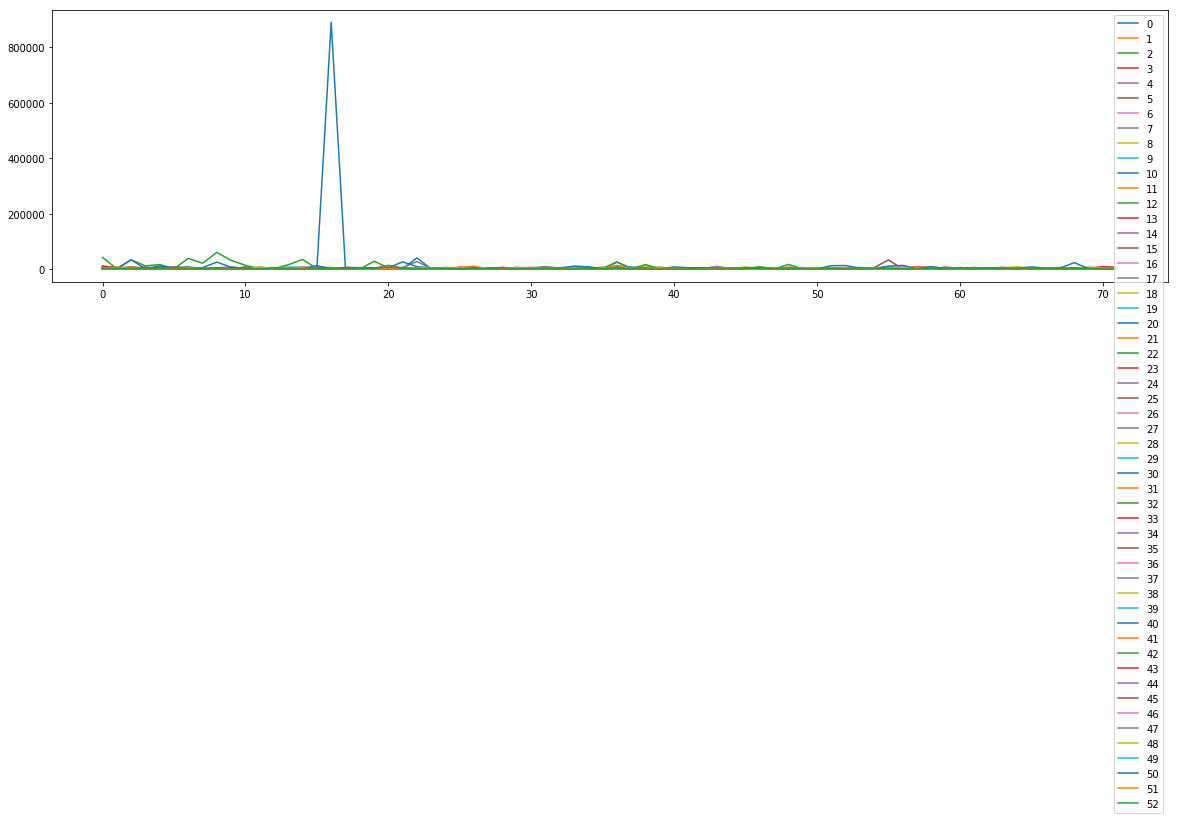

In [11]:
times = pd.DataFrame(d, columns=["Study ID", "Participant ID", "Test ID", "Test type", "Response time"])
times.set_index(["Study ID", "Participant ID", "Test ID", "Test type"], inplace=True)
times = pd.DataFrame(times.values.reshape((-1,72)))
#display(times)
times.T.plot(figsize=(20,5))

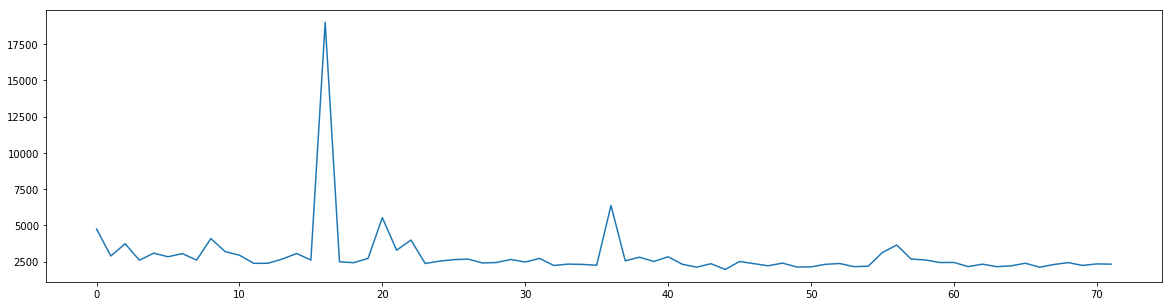

In [12]:
times.mean().plot(figsize=(20,5))